# "Predicting the Sentiment of Movie Reviews with NLP"
> "By fine-tuning a language model on movie reviews, can we predict if they're positive or negative?"

- categories: [nlp]

In [ ]:
#hide
!pip install -Uqq fastbook tornado==5.1.0
import fastbook
from google.colab import drive
drive.mount('/content/gdrive/', force_remount=True)

In [2]:
#hide
from fastbook import *
from IPython.display import display, HTML

## Downloading the data set

If you didn't know, I work on Colab; I don't own a GPU that I can use to train models on my own. Whenever I download data sets, I end up having to redownload them when I come back on the next day. This time, before we get into the main topic, I want to show how I've been able to download the data sets into my Google drive so that I don't have to redownload them every time. It's also helpful since I can save the pickles to the same folder instead of saving them on my laptop and having to upload them later. 

It's really simple too: you mount onto your drive and then `cd` to your desired folder. When you download data sets, you download them into that folder. But, if you use `untar_data`, you have to move the files to the folder since it only saves to `~/.fastai/...`. 

In [3]:
!mkdir -p '/content/gdrive/MyDrive/data_sets/'
%cd '/content/gdrive/MyDrive/data_sets/'

/content/gdrive/MyDrive/data_sets


There's also a difference between `!` and `%` in Colab: `!` is like a "no side-effect" way to do command-line commands. `!mkdir ...` will make a directory, and `!cd ...` will change directories, except it doesn't, because that would be a side effect. So, to actually change the current directory that Colab is in, you have to use `%`. You can think of `%` as being able to change the variables stored in Colab; hypothetically `%cd path` makes Colab's `CURRENT_PATH = path`. 

In [4]:
from fastai.text.all import *

In [5]:
path = untar_data(URLs.IMDB_SAMPLE); path

Path('/root/.fastai/data/imdb_sample')

In [6]:
!mv {str(path)} '/content/gdrive/MyDrive/data_sets/imdb_sample'

In [7]:
path = Path('/content/gdrive/MyDrive/data_sets/imdb_sample')

In [8]:
!ls {str(path)}

texts.csv


## Preparing the data for the language model

To get the data from the data set, we'll use fastai's `get_text_files` as opposed to `get_image_files` that we did for computer vision problems. By specifying a list for `folders`, `get_text_files` will only look for text files in those folders. 

In [12]:
df = pd.read_csv(path/'texts.csv', low_memory=False)
df.head(3)

,label,text,is_valid
0,negative,"Un-bleeping-believable! Meg Ryan doesn't even look her usual pert lovable self in this, which normally makes me forgive her shallow ticky acting schtick. Hard to believe she was the producer on this dog. Plus Kevin Kline: what kind of suicide trip has his career been on? Whoosh... Banzai!!! Finally this was directed by the guy who did Big Chill? Must be a replay of Jonestown - hollywood style. Wooofff!",False
1,positive,"This is a extremely well-made film. The acting, script and camera-work are all first-rate. The music is good, too, though it is mostly early in the film, when things are still relatively cheery. There are no really superstars in the cast, though several faces will be familiar. The entire cast does an excellent job with the script.<br /><br />But it is hard to watch, because there is no good end to a situation like the one presented. It is now fashionable to blame the British for setting Hindus and Muslims against each other, and then cruelly separating them into two countries. There is som...",False
2,negative,"Every once in a long while a movie will come along that will be so awful that I feel compelled to warn people. If I labor all my days and I can save but one soul from watching this movie, how great will be my joy.<br /><br />Where to begin my discussion of pain. For starters, there was a musical montage every five minutes. There was no character development. Every character was a stereotype. We had swearing guy, fat guy who eats donuts, goofy foreign guy, etc. The script felt as if it were being written as the movie was being shot. The production value was so incredibly low that it felt li...",False


Then, we'll go straight into putting it into a `DataBlock` from which we can make our `DataLoaders`:

In [94]:
dls_lm = DataBlock(
            blocks=TextBlock.from_df(['text'], is_lm=True),
            get_items=ColReader('text'),
            splitter=RandomSplitter(0.1)).dataloaders(df, path=path)

When we show a batch, you can see how the independent variable contains one more token before the dependent variable, but has one less token at the end. Fastai also has special tokens that it makes through `TextBlock` (which uses the `Tokenizer` class):
- `xxbos`: beginning of stream.
- `xxeos`: end of stream.
- `xxmaj`: next token is capitalized.
- `xxunk`: unknown (we ignore tokens that don't appear enough to minimize the size of the embedding matrix).
- `xxup`: next token is all uppercase.
- `xxrep` followed by a number `n`: the next actual token repeats `n` times.

In [95]:
dls_lm.show_batch(max_n=2)

,text,text_
0,xxbos xxmaj even though the book was n't strictly accurate to the real situation it described it still carried a sense of xxmaj japan . i find it hard to believe that anyone who was involved in making this film had ever been to japan as it did n't feel xxmaj japanese in the slightest . xxmaj almost everything about it was terrible . i will admit the actors were generally quite,xxmaj even though the book was n't strictly accurate to the real situation it described it still carried a sense of xxmaj japan . i find it hard to believe that anyone who was involved in making this film had ever been to japan as it did n't feel xxmaj japanese in the slightest . xxmaj almost everything about it was terrible . i will admit the actors were generally quite good
1,"; "" the xxmaj return "" ( xxunk xxmaj xxunk , 2003 ) ; "" little xxmaj xxunk "" ( james xxmaj xxunk ) ; xxmaj xxunk , "" xxunk and xxmaj sons "" ; and , of course , xxmaj xxunk , "" the xxmaj brothers xxmaj xxunk . "" \n\n xxmaj credits in xxmaj english indicate intended international xxunk , meaning that the excuse can not be used that you",""" the xxmaj return "" ( xxunk xxmaj xxunk , 2003 ) ; "" little xxmaj xxunk "" ( james xxmaj xxunk ) ; xxmaj xxunk , "" xxunk and xxmaj sons "" ; and , of course , xxmaj xxunk , "" the xxmaj brothers xxmaj xxunk . "" \n\n xxmaj credits in xxmaj english indicate intended international xxunk , meaning that the excuse can not be used that you have"


In general, `Tokenizer` does a lot of extra things on top of tokenizing the texts:

In [90]:
defaults.text_proc_rules

[<function fastai.text.core.fix_html>,
 <function fastai.text.core.replace_rep>,
 <function fastai.text.core.replace_wrep>,
 <function fastai.text.core.spec_add_spaces>,
 <function fastai.text.core.rm_useless_spaces>,
 <function fastai.text.core.replace_all_caps>,
 <function fastai.text.core.replace_maj>,
 <function fastai.text.core.lowercase>]

Where
- `fix_html`: replace special HTML characters with a readable version.
- `replace_rep`: replace characters repeated three or more times with `xxrep n c` where `xxrep` is the special token, `n` is the number of times it repeats, and `c` is the character.
- `replace_wrep`: replace words repeated three or more times with `xxwrep n w` where `w` is the word.
- `spec_add_spaces`: add spaces around special characters like `/` and `#` so they get split into separate tokens.
- `rm_useless_spaces`: remove repeated spaces.
- `replace_all_caps`: lowercase a word in all caps and add a `xxup` before it.
- `replace_maj`: lowercase a capitalized word and add a `xxmaj` before it.
- `lowercase`: lowercase all words and add a `xxbox` to the beginning and/or `xxeos` to the end of the string. 

To show most of it in action:

In [96]:
tok = WordTokenizer()
tkn = Tokenizer(tok)
list(tkn('amp; &copy;   #a" <br />  www.google.ca/INDEX.html wow wow wow'))

['xxbos',
 '&',
 '©',
 '#',
 'a',
 '"',
 '\n ',
 'xxrep',
 '3',
 'w',
 '.google.ca',
 '/',
 'index.html',
 'xxwrep',
 '3',
 'wow']

## Fine-tuning the language model

We'll be fine-tuning a language model pretrained using text from Wikepedia. This model uses a recurrent neural network using the AWD-LSTM architecture.  

In [105]:
learn = language_model_learner(dls_lm, AWD_LSTM, drop_mult=0.3, metrics=[accuracy, Perplexity()])

In [106]:
#hide
learn.save('pre')

Path('/content/gdrive/MyDrive/data_sets/imdb_sample/models/pre.pth')

Since `pretrained` is set to `True` for our `language_model_learner` by default, all the layers except the head are frozen. So, we'll first train the head of the model for one epoch:   

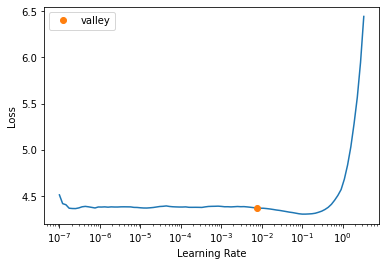

In [107]:
lr = learn.lr_find().valley

In [110]:
#hide
learn = learn.load('pre')

In [111]:
learn.fit_one_cycle(1, lr)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,4.127933,3.944165,0.272763,51.633183,00:57


In [112]:
#hide
learn.save('one')

Path('/content/gdrive/MyDrive/data_sets/imdb_sample/models/one.pth')

Then, we'll unfreeze all the layers and train all the layers for another epoch:

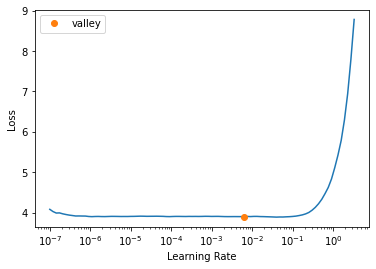

In [113]:
lr = learn.lr_find().valley

In [117]:
#hide
learn = learn.load('one')

In [118]:
learn.unfreeze()
learn.fit_one_cycle(1, lr)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,3.904036,3.806237,0.281909,44.980846,01:04


We'll save the model as an **encoder**, which is the *body* of the model (the model not including the task-specific final layer(s)):

In [121]:
learn.save_encoder('lm')

In [124]:
learn.predict("I liked the book better", 25, temperature=0.75)

"i liked the book better , i had more movie time , so i was surprised , but i do n't like it . While i essentially liked this"

## Fine-tuning the language model for a classifier

Unlike language models, which are self-supervised, we have to provide our `DataLoaders` for our classifier with the labels:

In [130]:
dls_c = DataBlock(
    blocks    =(TextBlock.from_df('text', vocab=dls_lm.vocab), CategoryBlock),
    get_x     =ColReader('text'),
    get_y     =ColReader('label'),
    splitter  =ColSplitter()
    ).dataloaders(df, path=path)

This time, we have to specify our `blocks` differently such that our independent variable is a `TextBlock` and our dependent variable is a `CategoryBlock`. So, when show a part of a batch, it'll look different from a language model's `DataLoaders`:

In [131]:
dls_c.show_batch(max_n=2)

,text,category
0,"xxbos xxmaj raising xxmaj victor xxmaj vargas : a xxmaj review \n\n xxmaj you know , xxmaj raising xxmaj victor xxmaj vargas is like sticking your hands into a big , xxunk bowl of xxunk . xxmaj it 's warm and xxunk , but you 're not sure if it feels right . xxmaj try as i might , no matter how warm and xxunk xxmaj raising xxmaj victor xxmaj vargas became i was always aware that something did n't quite feel right . xxmaj victor xxmaj vargas suffers from a certain xxunk on the director 's part . xxmaj apparently , the director thought that the ethnic backdrop of a xxmaj latino family on the lower east side , and an xxunk storyline would make the film critic proof . xxmaj he was right , but it did n't fool me . xxmaj raising xxmaj victor xxmaj vargas is",negative
1,"xxbos xxup the xxup shop xxup around xxup the xxup corner is one of the xxunk and most feel - good romantic comedies ever made . xxmaj there 's just no getting around that , and it 's hard to actually put one 's feeling for this film into words . xxmaj it 's not one of those films that tries too hard , nor does it come up with the xxunk possible scenarios to get the two protagonists together in the end . xxmaj in fact , all its charm is xxunk , contained within the characters and the setting and the plot … which is highly believable to xxunk . xxmaj it 's easy to think that such a love story , as beautiful as any other ever told , * could * happen to you … a feeling you do n't often get from other romantic comedies",positive


Next, we'll define a `Learner` by using the `text_classifier_learner` class and load the encoder. 

In [132]:
learn = text_classifier_learner(dls_c, AWD_LSTM, drop_mult=0.5, metrics=accuracy)

In [133]:
learn = learn.load_encoder('lm')

When fine-tuning a language model for a text classifier, it's recommended to use discriminative learning rates and gradual unfreezing. So, we'll first fine-tune it for 1 epoch:

In [134]:
learn.fit_one_cycle(1, 2e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.587637,0.625740,0.655000,00:16


Then unfreeze the last 2 layers:

In [135]:
den = 2.6**4
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(1e-2/den, 1e-2))

epoch,train_loss,valid_loss,accuracy,time
0,0.445948,0.522101,0.715000,00:19


Unfreeze up to the last 3 layers:

In [136]:
learn.freeze_to(-3)
learn.fit_one_cycle(1, slice(5e-3/den, 5e-3))

epoch,train_loss,valid_loss,accuracy,time
0,0.306446,0.478002,0.780000,00:28


And unfreeze the entire model:

In [137]:
learn.unfreeze()
learn.fit_one_cycle(2, slice(1e-3/den, 1e-3))

epoch,train_loss,valid_loss,accuracy,time
0,0.208012,0.417342,0.795000,00:36
1,0.193315,0.410684,0.805000,00:36


And train for a few more epochs:

In [161]:
learn.fit_one_cycle(5, 1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.162276,0.398424,0.820000,00:36
1,0.146796,0.461882,0.790000,00:36
2,0.114655,0.511482,0.835000,00:36
3,0.092193,0.437872,0.825000,00:35
4,0.074616,0.423975,0.835000,00:36


In [186]:
#hide
learn.save('imdb_sample')

Path('/content/gdrive/MyDrive/data_sets/imdb_sample/models/imdb_sample.pth')

And we're done! We can try predicting with a few of Morbius' reviews:

In [191]:
[learn.predict(i) for i in [
"So many choices... just seem halfhearted. They're not terrible, but they're also not interesting.",
"Doesn't deliver a lot of high notes, but it's not unwatchable (especially if you enjoy the vampire genre). \"Morbius\" is not as great as you'd hoped, but not as bad as you feared.",
"Overall, this is an entertaining movie. It sucks you in with the action and standout scenes between some of the characters. But, while Morbius has the makings of a great anti-hero revival, it wavers with the execution.",
"Like the Venom films and unlike the MCU movies Morbius eschews the mythmaking of the Avengers for darkly comic horror.",
"Sadly, director Daniel Espinosa's action horror is itself drained of atmosphere, shocks and drama."
]]

[('negative', TensorText(0), TensorText([0.9590, 0.0410])),
 ('negative', TensorText(0), TensorText([0.8723, 0.1277])),
 ('positive', TensorText(1), TensorText([0.0055, 0.9945])),
 ('positive', TensorText(1), TensorText([0.0279, 0.9721])),
 ('negative', TensorText(0), TensorText([0.5976, 0.4024]))]

## Conclusion

In this blog, I applied the ULMFiT approach to NLP. I fine-tuned the pretrained language model that was trained on Wikepedia pages with the smaller version of the IMDB data set to create a language model that can generate text relevant to movie reviews. Then, I used the encoder from that model to train a movie review sentiment classifier with an accuracy of 83.5%. For a model that was only trained with 1000 reviews, it's not that bad! 

For next steps, I'd like to train a model using the full IMDB data set, but I don't have the necessary hardware to do it in a reasonable time. When I tried training a `Learner` on the full data set, the estimated time for the first epoch was two and a half hours. Maybe in the future when I pay for a GPU server or own my own setup. 